#Library

In [1]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model


# **Prepare datasets**

In [3]:
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)

In [4]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [5]:
df.shape

(11000, 2)

In [6]:
df.columns =['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#Check Data

In [7]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

In [35]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



#Dataset Over Sampling

In [36]:
df_positive = df[df['label']=='positive']
df_negative = df[df['label']=='negative']
df_neutral = df[df['label']=='neutral']

In [37]:
df_over_negative = df_negative
df_over_neutral = df_neutral
df_positive
print('df_over_negative :', df_over_negative.shape)
print('df_over_neutral :', df_over_neutral.shape )
print('df_positive :', df_positive.shape )

df_over_negative : (3436, 2)
df_over_neutral : (1148, 2)
df_positive : (6416, 2)


In [38]:
df_oversampling = df_over_negative.sample(df_positive.shape[0],replace = True)
df_oversampling.shape

(6416, 2)

In [39]:
df_oversampling

,text,label
5984,menu di sini banyak yang baru terutama sushi n...,negative
7851,bagikan sebanyak-banyaknya . biar ini orang di...,negative
10000,minimal baca dong keluhan di inbox dulu bagus ...,negative
7570,untuk menuju ke tempat ini jalan nya sangat ma...,negative
5217,"sampai hari ini , gue masih belum menyesal pil...",negative
...,...,...
9541,kebiasaan kelompok wahabi di indonesia harus d...,negative
10862,bocah goblok ya kayak gitu . sudah di rawat da...,negative
9195,negara bersih bukan karena kpk tapi karena dem...,negative
5071,"biasanya mulai macet itu di kami 9,8,7 eh ini ...",negative


In [40]:
df_neutralover = df_over_neutral.sample(df_positive.shape[0], replace = True)
df_neutralover.shape

(6416, 2)

In [41]:
df_neutralover

,text,label
919,jual blue daily half time by alexia hanya rp 8...,neutral
3896,anies akan terjunkan tim pemburu binatang buas...,neutral
8806,"berubah status jadi universitas , bsi gelar se...",neutral
8694,jual pembalut pergelangan tangan wrist band / ...,neutral
1946,bali adalah salah satu pulau yang menjadi tuju...,neutral
...,...,...
9708,minimal maaf saya semalam dapat order dari reg...,neutral
311,"berita indonesia : perdagangan bei ditutup , p...",neutral
2017,bersama srikandi anggota dpr ri melani leimena...,neutral
3416,sore ini jokowi jemput kedatangan private mess...,neutral


In [42]:
df_oversamplingnew = pd.concat([df_oversampling,df_neutralover,df_positive ])
df_oversamplingnew.shape

(19248, 2)

In [43]:
df = df_oversamplingnew

In [44]:
df.label.value_counts()

negative    6416
neutral     6416
positive    6416
Name: label, dtype: int64

In [45]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [46]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

#merubah kata kata alay menjadi kata kata baku
#def normalize_alay(text):
    #return ' '.join([data_alay_new_map[word] if word in data_alay_new_map else word for word in text.split(' ')])
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    #text = normalize_alay(text) # 3
    return text


In [47]:
df['text_clean'] = df.text.apply(preprocess)

In [48]:
df.head()

,text,label,text_clean
5984,menu di sini banyak yang baru terutama sushi n...,negative,menu di sini banyak yang baru terutama sushi n...
7851,bagikan sebanyak-banyaknya . biar ini orang di...,negative,bagikan sebanyak banyaknya biar ini orang dipr...
10000,minimal baca dong keluhan di inbox dulu bagus ...,negative,minimal baca dong keluhan di inbox dulu bagus ...
7570,untuk menuju ke tempat ini jalan nya sangat ma...,negative,untuk menuju ke tempat ini jalan nya sangat ma...
5217,"sampai hari ini , gue masih belum menyesal pil...",negative,sampai hari ini gue masih belum menyesal pilih...


#Sortir Data Berdasarkan 3 Sentimen

In [49]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6416, Neu: 6416, Neg: 6416
Total data: 19248


#Feature Extraction

In [50]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [51]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


#Split Dataset For Training & Testing

In [52]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (LSTM)

In [53]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1540/1540 [==============================] - 235s 151ms/step - loss: 0.3344 - accuracy: 0.8741 - val_loss: 0.1908 - val_accuracy: 0.9309
Epoch 2/10
1540/1540 [==============================] - 231s 150ms/step - loss: 0.1071 - accuracy: 0.9629 - val_loss: 0.1529 - val_accuracy: 0.9478
Epoch 3

#Evaluation

In [54]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

121/121 [==============================] - 4s 26ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1255
           1       0.97      1.00      0.98      1275
           2       0.96      0.92      0.94      1320

    accuracy                           0.96      3850
   macro avg       0.96      0.96      0.96      3850
weighted avg       0.96      0.96      0.96      3850



#Cross Validation

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/10
880/880 [==============================] - 13s 14ms/step - loss: 0.4550 - accuracy: 0.8173 - val_loss: 0.3353 - val_accuracy: 0.8800
Epoch 2/10
880/880 [==============================] - 11s 12ms/step - loss: 0.2019 - accuracy: 0.9272 - val_loss: 0.3413 - val_accuracy: 0.8709
Epoch 3/10
880/880 [==============================] - 11s 13ms/step - loss: 0.1044 - accuracy: 0.9589 - val_loss: 0.4135 - val_accuracy: 0.8655
Epoch 4/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0659 - accuracy: 0.9756 - val_loss: 0.4595 - val_accuracy: 0.8718
Epoch 5/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0388 - accuracy: 0.9858 - val_loss: 0.5611 - val_accuracy: 0.8664
Epoch 6/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0308 - accuracy: 0.9908 - val_loss: 0.5937 - val_accuracy: 0.8673
Epoch 7/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.6668 - val_accuracy:

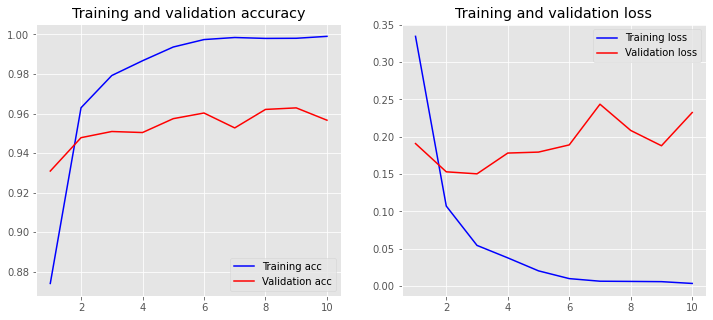

In [55]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [56]:
model.save('model.h5')
print('Model has created!')

Model has created!


#Testing Model

In [58]:
input_text = """ 
TIDAK bersyukur..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 1s 766ms/step
Text:   tidak bersyukur 
Sentiment:  negative
